In [423]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from linear_regression import LinearRegression
from gurobipy import GRB
import algorithms
import postprocessing

## Load and Plot Data.

In [ ]:
# Read in housing price data: https://www.kaggle.com/code/imdevskp/house-price-prediction-using-regression
hp = pd.read_csv('data/HP.csv')
# select columns
hp_short = hp[['MSSubClass', 'LotFrontage', 'LotArea', 'PoolArea', 'SalePrice', 'MoSold']]
hp_short.head()

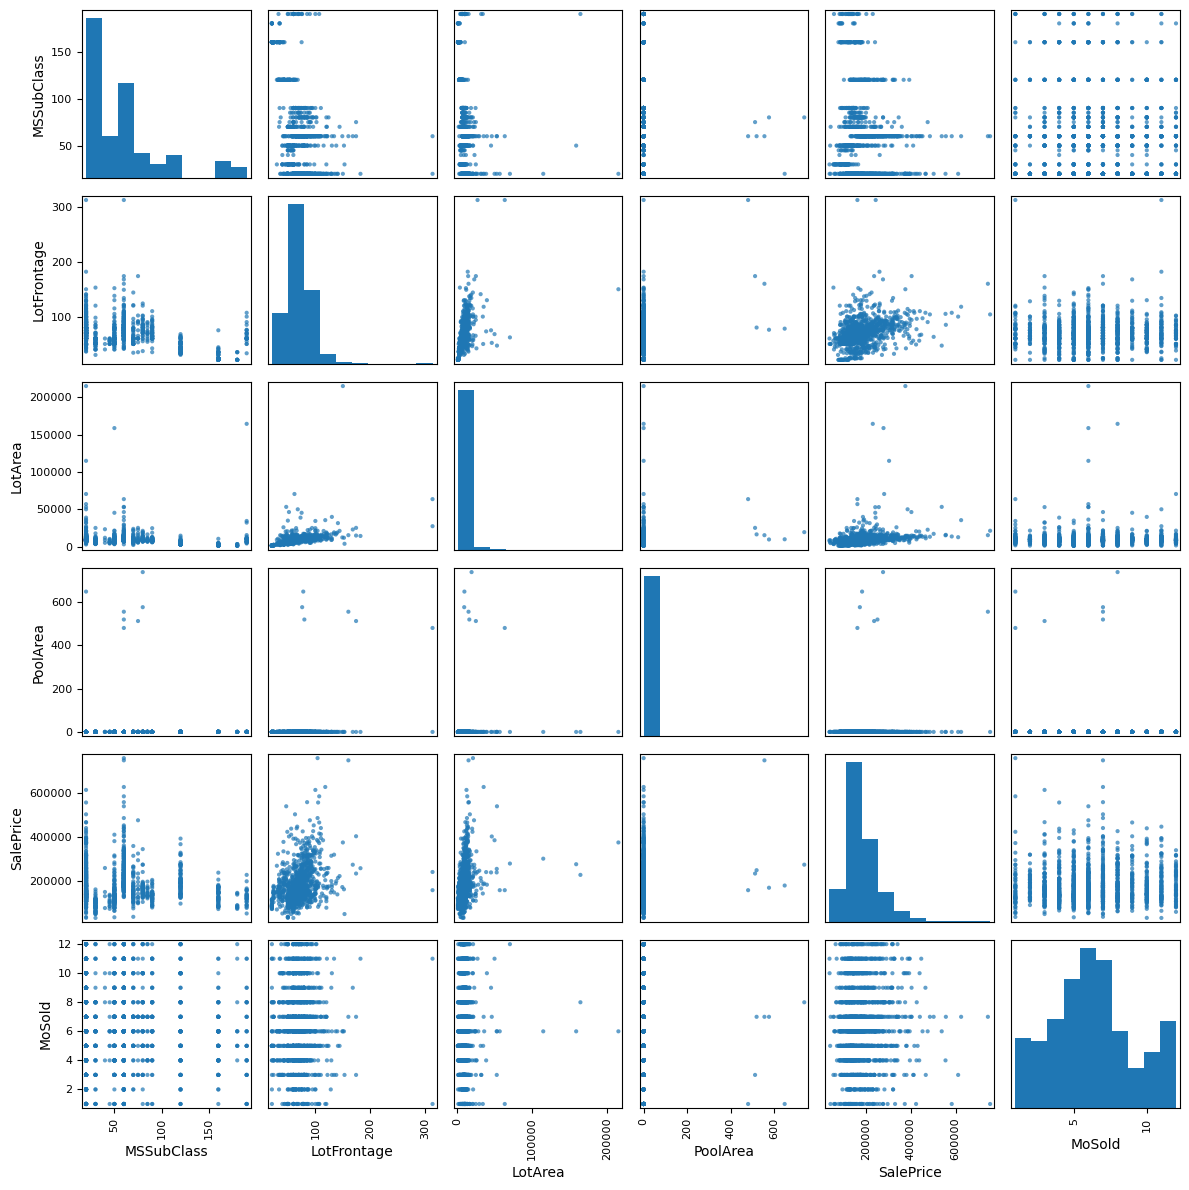

In [316]:
from pandas.plotting import scatter_matrix
scatter_matrix(hp_short, figsize=(12, 12), diagonal='hist', alpha=0.7)

plt.tight_layout()
plt.show()

Below, we thinned the data by taking 400 random points plus the outliers. We thin the data so that three outliers is just around 1% of the data.

In [ ]:
### thin the data. 
# print outlier indices.
outlier_index = hp_short[hp_short['PoolArea'] > 200].index
print(outlier_index)
# filter out outliers.
hp_inliers = hp_short.drop(outlier_index)
hp_inliers
# select 400 data points from inliers to keep. we thin the data 
np.random.seed(1)
keep_indices = np.random.choice(hp_inliers.index, size=400, replace=False)
hp_thinned = hp_inliers.loc[keep_indices].reset_index(drop=True)
# re-add the outliers.
hp_final = pd.concat([hp_thinned, hp_short.loc[outlier_index]]).reset_index(drop=True)
hp_final = hp_final.dropna() # one of the outliers had a missing value.

Index([197, 810, 1170, 1182, 1298, 1386, 1423], dtype='int64')


In [396]:
hp_final.shape

(340, 6)

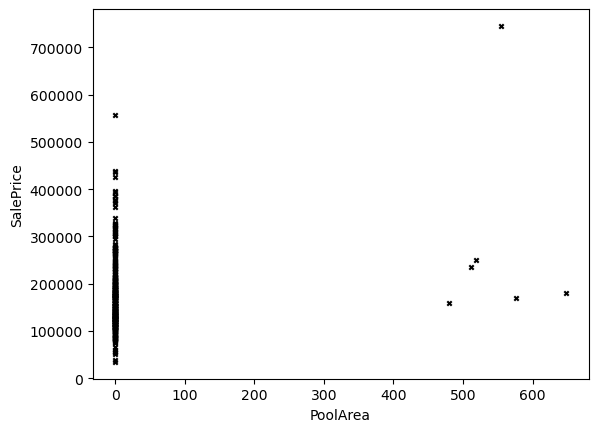

In [397]:
# create a scatter plot of Fpv Open vs. Fpv Close
plt.scatter(hp_final['PoolArea'], hp_final['SalePrice'], s=10, c='black', marker='x')

plt.xlabel('PoolArea')
plt.ylabel('SalePrice')
plt.show()

In [ ]:
# fit a linear regression on pool area.
xc1 = hp_final['PoolArea'].to_numpy()
# xc2 = hp_final['LotArea'].to_numpy()
# xc3 = hp_final['LotFrontage'].to_numpy()
mat = np.vstack([xc1])
mat_final = mat.T

# the response variable is sales price.
y = hp_final['SalePrice'].to_numpy()

# Add in an intercept term to the first column of the design.
df = pd.DataFrame(mat_final)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr

In [377]:
# fit the model
lr = LinearRegression(x=x.T, y=y)
lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)

Estimated beta1 with full dataset: 207.78106849811658


In [ ]:
# Compute condition number of design matrix.
print(
    f"Condition number of full dataset: {np.linalg.cond(x)}"
)

Condition number of full dataset: 73.8445099528737


## Data-Dropping Approximations.

### Netapprox.

In [ ]:
# NetApprox is run with the intercept in the last column of the design matrix.
Xnet = np.hstack([x[:, 1:], x[:, [0]]])

In [ ]:
trials = 1000
n_sumwstar, wstar = algorithms.net_algorithm(Xnet,y,1000)
# In order to use NetApprox for the MIS identification problem, 
# we set the alphaN closest-to-0 weight points to be the MIS.
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
alphaN = 3
mis_inds = np.argsort(wstar)[:alphaN]
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 2.8990316387552753


array([339, 337, 334])

We check that dropping the MIS does indeed induce a sign change.

In [381]:
inds = mis_inds
new_x= np.delete(x, inds, axis=0)
new_y= np.delete(y, inds, axis=0)
print(new_x.shape)
print(new_y.shape)

lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset: {modified_lr_na.beta[1]}"
)

(337, 2)
(337,)
Estimated beta1 with full dataset: 207.78106849811658
Estimated beta1 after removing subset: -6.66866446373473


### FH-Gurobi (warm-start)

In [ ]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x, y, intercept=True, time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

In [ ]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

In [ ]:
# to use FH-Gurobi to identify the MIS, we select the MIS to be points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove, len(indices_to_remove)

(array([334, 337, 339]), 3)

In [402]:
#### Refit after Removing Flagged Points.
mis_inds = indices_to_remove
new_x= np.delete(x, mis_inds, axis=0)
new_y= np.delete(y, mis_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(337, 2)
(337,)


In [404]:
# Refit after removing the points specified by FH-Gurobi (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)

modified_lr = LinearRegression(x=new_x.T, y=new_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset specified by FH-Gurobi: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 207.78106849811658
Estimated beta1 after removing subset specified by FH-Gurobi: -6.66866446373473


### FH-Gurobi

In [ ]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

In [406]:
weights_array = np.array([w.X for w in weights])

In [407]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(weights_array == 0)[0]
indices_to_remove

array([334, 337, 339])

In [409]:
Gurobi_inds=indices_to_remove
new_x= np.delete(x, Gurobi_inds, axis=0)
new_y= np.delete(y, Gurobi_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(337, 2)
(337,)


In [410]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_g = LinearRegression(x=new_x.T, y=new_y)
modified_lr_g.fit()
print(
    f"Estimated beta1 after removing subset specified by gurobi: {modified_lr_g.beta[1]}"
)

Estimated beta1 with full dataset: 207.78106849811658
Estimated beta1 after removing subset specified by gurobi: -6.66866446373473


### Additive Algorithms.

In [411]:
scores_df = postprocessing.compute_scores(x, y, lr, True)

In [412]:
scores_df.head()

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,0,82500,-93072.318484,0.002993,-0.503198,-0.504709,337,337,-138.361809,-166.519396
1,0,107500,-68072.318484,0.002993,-0.368035,-0.369140,269,269,-0.760549,-0.762833
2,0,136500,-39072.318484,0.002993,-0.211246,-0.211880,106,106,-0.732976,-0.735177
3,0,153000,-22572.318484,0.002993,-0.122038,-0.122404,89,89,-0.668098,-0.670104
4,0,172500,-3072.318484,0.002993,-0.016611,-0.016660,324,324,-0.651878,-0.653835


In [414]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(scores_df["sorted_IF_scores"][:3]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size 3 is {round(lr.beta[1] + sum(scores_df["sorted_1Exact_scores"][:3]), 4)}.')

The AMIP approximation of the refit is 67.9257.
The Add-1Exact for the change induced by dropping the worst-case subset of size 3 is 39.7637.


In [415]:
amip_inds = scores_df['sorted_IF_indices'][:3].values
oneexact_inds = scores_df['sorted_1Exact_indices'][:3].values

In [416]:
#### Refit after Removing Flagged Points.
new_amip_x= np.delete(x, amip_inds, axis=0)
new_amip_y= np.delete(y, amip_inds, axis=0)
print(new_amip_x.shape)
print(new_amip_y.shape)

new_1exact_x= np.delete(x, oneexact_inds, axis=0)
new_1exact_y= np.delete(y, oneexact_inds, axis=0)
print(new_1exact_x.shape)
print(new_1exact_y.shape)

# Fit to the full dataset.
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)

modified_lr = LinearRegression(x=new_amip_x.T, y=new_amip_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset specified by AMIP: {modified_lr.beta[1]}"
)
modified_lr = LinearRegression(x=new_1exact_x.T, y=new_1exact_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset specified by 1Exact: {modified_lr.beta[1]}"
)

(337, 2)
(337,)
(337, 2)
(337,)
Estimated beta1 with full dataset: 207.78106849811658
Estimated beta1 after removing subset specified by AMIP: 39.758382446150925
Estimated beta1 after removing subset specified by 1Exact: 39.758382446150925


#### Plot data.

In [ ]:
mis_inds = [339, 337, 334] # (results from NetApprox.)
setminus_mis_inds = [i for i in range(340) if i not in mis_inds]

# retrieve all values that that are in mis_inds.
mis_df = hp_final.iloc[mis_inds]
mis_x = mis_df['PoolArea']
mis_y = mis_df['SalePrice']
# retrieve the x values that are not in mis_inds.
not_mis_df = hp_final.iloc[setminus_mis_inds]
not_mis_x = not_mis_df['PoolArea']
not_mis_y = not_mis_df['SalePrice']

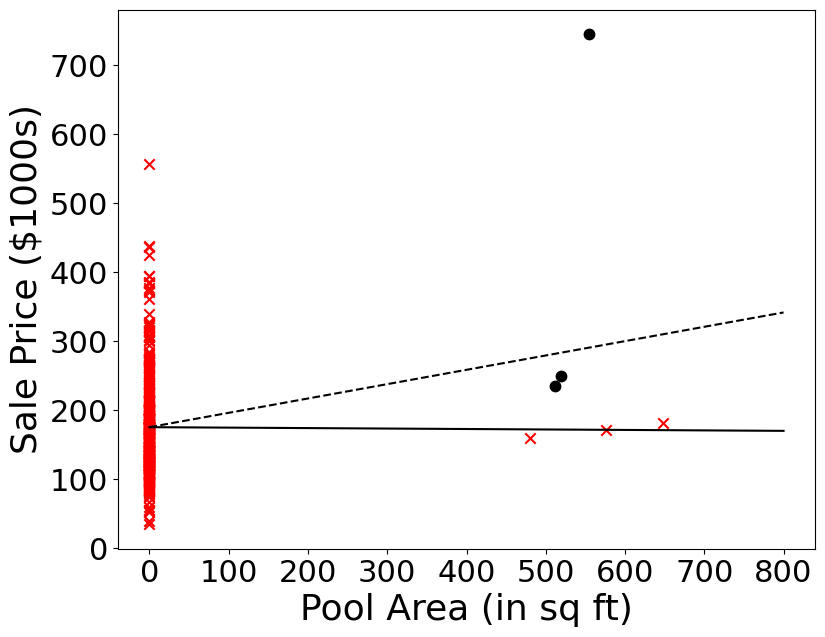

In [461]:
### create scatter plot.
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda y, _: f'{y / 1000:.0f}')  # or use 100 if you want "in hundreds"

plt.figure(figsize=(9, 7))

plt.scatter(not_mis_x, not_mis_y, marker='x', color='red', s=56)
plt.scatter(mis_x, mis_y, marker='o', color='black', s=56)

x_values = np.linspace(0, 800, 800)
y_values_full = lr.beta[1] * x_values + lr.beta[0]
y_value_red_crosses = modified_lr_g.beta[1] * x_values + modified_lr_g.beta[0]
plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Pool Area (in sq ft)', fontsize=26)
plt.ylabel('Sale Price ($1000s)', fontsize=26)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)
plt.savefig('house_scatter_1D.pdf')
plt.show()

### Greedy algorithms

In [424]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = postprocessing.create_orig_df(orig_x, orig_y, lr)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

inds [337 269 106  89 324  21 321 187 316 196]
newton_inds [337 269 106  89 324  21 321 187 316 196]


In [ ]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = algorithms.Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, method='if')

In [428]:
#### Refit after Removing Flagged Points.
greedy_inds = dropped_order[:3]
new_x= np.delete(orig_x, greedy_inds, axis=0)
new_y= np.delete(orig_y, greedy_inds, axis=0)
orig_x.shape, new_x.shape

((340, 2), (337, 2))

In [429]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=orig_x.T, y=orig_y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr = LinearRegression(x=new_x.T, y=new_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 207.78106849811658
Estimated beta1 after removing subset: -6.66866446373473
